# Exercise 4. Clustering

In this exercise k-means clustering is used for finding 5 clusters from a Sentinel satellite image, that has 8 bands: 4 bands for two dates.

In [1]:
from sklearn.cluster import KMeans
import rasterio
import numpy as np
import os
import time
from rasterio.windows import from_bounds

In [2]:
### File paths.
### Change the base_folder if needed

image_url = 'https://a3s.fi/gis-courses/gis_ml/image.tif'
multiclass_classification_url = 'https://a3s.fi/gis-courses/gis_ml/labels_multiclass.tif'

base_folder = ".."
outputBaseFolder= os.path.join(base_folder,'02_shallows')

image_file = os.path.join(base_folder, 'image.tif')
multiclass_classification_file = os.path.join(base_folder, 'labels_multiclass.tif')

outputImage = os.path.join(outputBaseFolder,'clustering_KMeans.tif')

no_bands_in_image = 8

(Download input data if needed.)

In [3]:
if not os.path.exists(image_file):
    urllib.request.urlretrieve(image_url, image_file)
     
if not os.path.exists(multiclass_classification_file):
    urllib.request.urlretrieve(multiclass_classification_url, multiclass_classification_file)   

## 4.1 Read data and shape it to suitable form for scikit-learn.

The satellite image has 8 channels, so rasterio reads it in as 3D data cube.

For scikit-learn we reshape the data to 2D, having in dataframe one row for each pixel. Each pixel has eight values, one for each band/date.

In [4]:
# Read the pixel values from .tif file as dataframe
with rasterio.open(image_file) as image_dataset:
    image_data = image_dataset.read(window=from_bounds(240500, 6775500, 253500, 6788500, image_dataset.transform))
    
# We have to change the data format from bands x width x height to width*height x bands
# This means that each pixel from the original dataset has own row in the result dataframe.
# Check shape of input data
print ('Dataframe original shape, 3D: ', image_data.shape)    

Dataframe original shape, 3D:  (8, 650, 650)


As a mid-step transponse the axis order, so that the bands are the last. Notice how the dataframe size changes.

In [5]:
# First move the bands to last axis.
image_data2 = np.transpose(image_data, (1, 2, 0))
# Check again the data shape, now the bands should be last.
print ('Dataframe shape after transpose, 3D: ', image_data2.shape) 

Dataframe shape after transpose, 3D:  (650, 650, 8)


Then reshape to 2D.

In [6]:
pixels = image_data2.reshape(-1, no_bands_in_image)
print ('Dataframe shape after transpose and reshape, 2D: ', pixels.shape) 

Dataframe shape after transpose and reshape, 2D:  (422500, 8)


*How many pixels there is?*

## 4.2 Calculate clusters

Find 5 clusters using 10 iterations. *Try also with for example 7 classes.*

*This takes a moment, please wait*

In [7]:
classes = KMeans(n_clusters=5, random_state=63, max_iter=10).fit_predict(pixels)

Check the results. *How many pixels each class has?*

In [8]:
np.unique(classes, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32),
 array([ 95736, 123933,  57706,  87110,  58015]))

## 4.3 Reshape results back to 2D raster

The clustering results are per pixel, so first reshape the data back to 2D raster.

In [9]:
print ('Dataframe shape, output, 1D: ', classes.shape) 

Dataframe shape, output, 1D:  (422500,)


In [10]:
#Reshape back to 2D    
classes2D = np.reshape(classes, (image_data.shape[1], image_data.shape[2]))
print ('Dataframe shape, output after reshape, 2D: ', classes2D.shape)  

Dataframe shape, output after reshape, 2D:  (650, 650)


## 4.4 Plot results

Create plots in similar way as in Exercise 2.

* Satellite image
* Clustering results
* Training labels

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors
%matplotlib inline
from rasterio.plot import show
from rasterio.plot import show_hist

In [15]:
### Help function for sentinel image plotting, to normalize band values and enhance contrast. Just like what QGIS does automatically
def normalize(array):
    min_percent = 2   # Low percentile
    max_percent = 98  # High percentile
    lo, hi = np.percentile(array, (min_percent, max_percent))
    return (array - lo) / (hi - lo)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


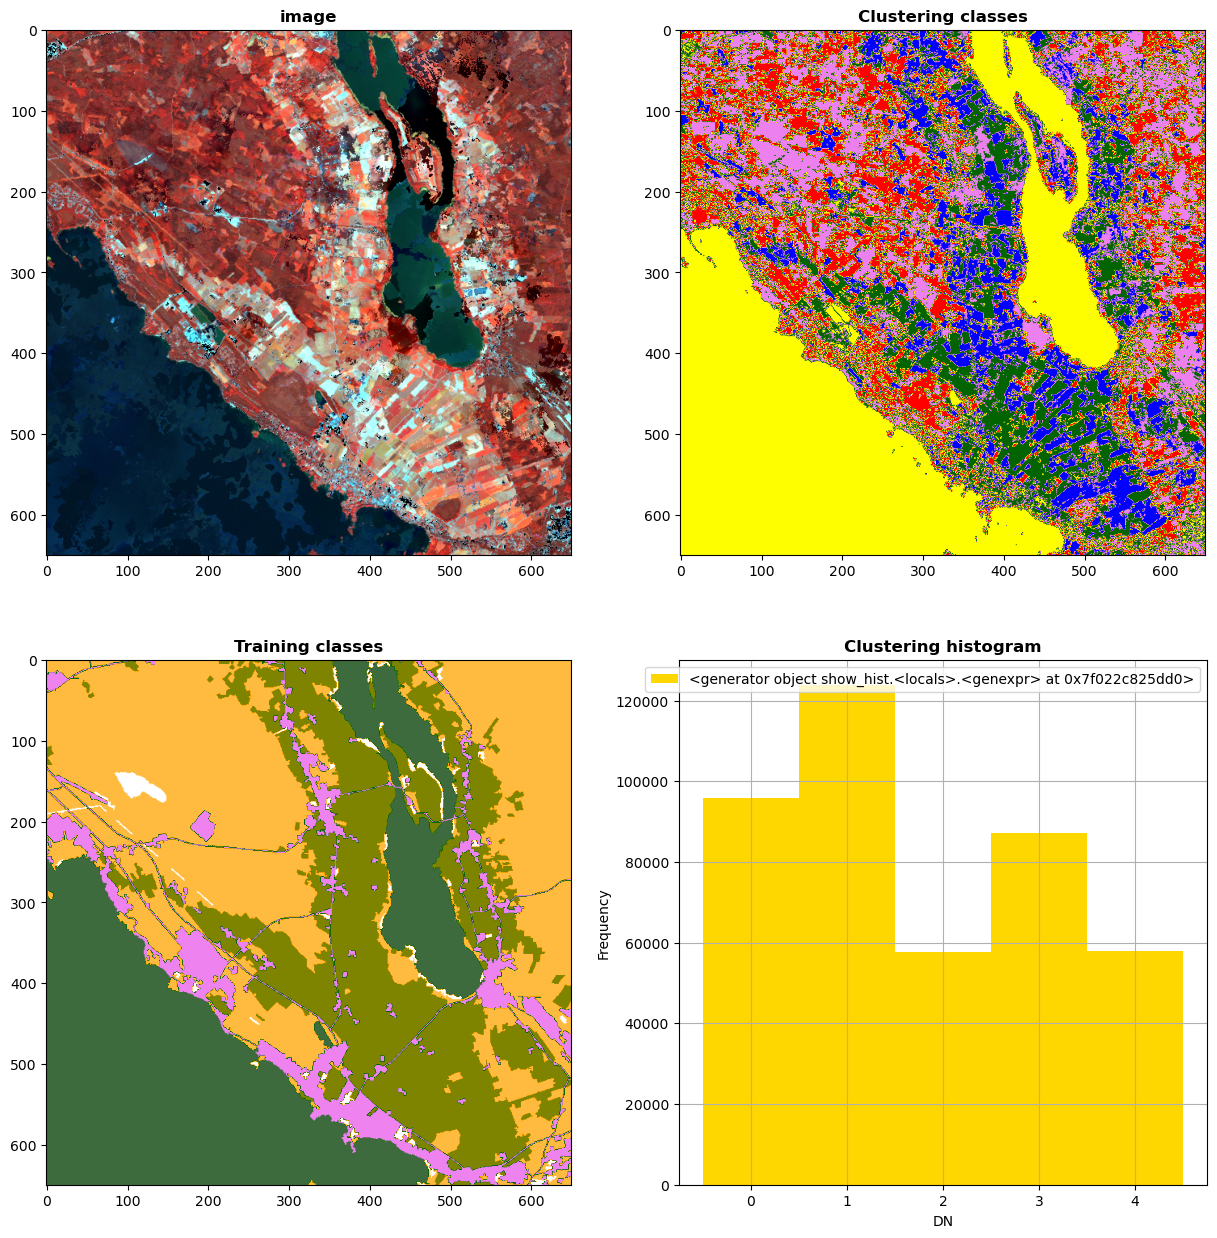

In [13]:
### Create a subplot for 4 images  
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))

# The Sentinel image   
# Read the bands separately and apply the normalize function to each of them to increase contrast
nir, red, green = image_data[7,], image_data[3,], image_data[1,]
nirn, redn, greenn = normalize(nir), normalize(red), normalize(green)
stacked = np.stack((nirn, redn, greenn))
show(stacked, ax=ax[0,0], title='image') 

### The clustering results
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","darkgreen","violet","blue"]) #,"white","black"
show(classes2D, ax=ax[0, 1], cmap=cmap, title='Clustering classes')

### The training multiclass labels
with rasterio.open(multiclass_classification_file) as src:
    labels_data = src.read(window=from_bounds(240500, 6775500, 253500, 6788500, src.transform))
    
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","darkgreen","violet"])
show(labels_data, ax=ax[1, 0], cmap=cmap, title='Training classes')

### The histogram of clustering results
show_hist(classes2D, ax=ax[1, 1], bins=[-0.5,0.5,1.5,2.5,3.5,4.5], title="Clustering histogram") #,5.5,6.5

## 4.4 Save results

Save the result to a GeoTiff file. First prepare the metadata of the new file - compared to the original file, the new file has onlyl 1 band and int32 data type.

In [14]:
meta = image_dataset.meta
meta.update(count=1, dtype='int32')
# Save the data
with rasterio.open(outputImage, 'w', **meta) as dst:
    dst.write(classes2D, 1)